# 데이터 수집

In [ ]:
import time
import re
import datetime as dt
import pandas as pd
import openpyxl as xl
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from tqdm import tqdm

def get_youtube_data(ent, idol):
    # 드라이버 주소 설정
    browser = webdriver.Chrome(".\chromedriver.exe") 
    browser.implicitly_wait(1)   
    
    # 크롤링 데이터를 저장할 경로 및 엑셀 파일 이름 지정
    try:      # 데이터 100개를 저장할 폴더 생성('YT_data') 및 이미 존재하는 폴더일 시 예외처리
        os.mkdir("new_YT_data") 
    except FileExistsError:
        print('YT_data 폴더가 이미 존재합니다. 해당 폴더에 데이터를 저장합니다.')
    
    result = pd.ExcelWriter(f"./new_YT_data/{ent}_{idol}.xlsx", engine='openpyxl')
    
    # 유튜브 검색을 위한 url을 만들어 열고 body 추출
    yt_url = "https://www.youtube.com"
    target_url  = yt_url + "/results?search_query="+ idol + "&sp=CAI%253D"      # 업로드날짜 순으로 필터링
    browser.get(target_url)
    body = browser.find_element(By.TAG_NAME, 'body')
    
    # 전체 데이터를 추출하기 위하여 페이지를 쭉 내림. 필터링이 되기 때문에 단순히 내리기만 하면 됨
    while True:  # 페이지 다운 수
        for pg_down in range(100):
            body.send_keys(Keys.PAGE_DOWN)
            browser.implicitly_wait(10)   
        # 해당 페이지 html 소스를 beautifulsoup을 이용하여 html 에 저장
        html0 = browser.page_source
        html = BeautifulSoup(html0,'html.parser')
        last_date = html.find_all('span',{"class" : "inline-metadata-item style-scope ytd-video-meta-block"})[-1].get_text()
        print(last_date)
        
        # 돌리던 중 영상이 끝난 경우(데뷔가 최근인 경우)
        try:
            msg = html.find_all('yt-formatted-string',{"class" : "style-scope ytd-message-renderer"})[0].get_text()
        except:
            msg = 1
            pass
        
        if msg == '결과가 더 이상 없습니다.':
            break
        if last_date[-3:] == "년 전": 
            break
    
    # 검색 결과창에서 각 비디오 하나씩을 나누어줌
    video_datas = html.find_all('ytd-video-renderer',{'class':'style-scope ytd-item-section-renderer'})

    
    #데이터 저장을 위한 기본 데이터프레임 생성
    dataframe = pd.DataFrame({'title':[], 'youtube_url':[], 'views':[], "nice":[], "reply":[], "upload":[]})
    
    # 비디오 url을 저장할 리스트 생성(해당 url은 youtube.com/ 이후에 들어가는 부분)
    video_url_list = []
    for i in range(len(video_datas)):
        # 검색 결과 창에서 얻을 수 있는 데이터인 동영상 제목(title)과 동영상 링크 추출
        title = video_datas[i].find('a',{'id':'video-title'}).get_text() 
        url = yt_url + video_datas[i].find('a',{'id':'thumbnail'})['href']
        video_url_list.append(url) # 이후 상세 페이지 접속에 사용
        
        if url.split('/')[-2] == 'shorts': # 쇼츠의 경우 상세 페이지 속 태그 형태가 다르므로 분류
            shorts = True
        else:
            shorts = False
        
        # 빠른 크롤링을 위해 조회수가 1만(임의) 이상인 동영상만 접속하도록 함
        try: # 조회수를 감춰두어 에러가 나는 경우가 있으므로 예외처리
            view = video_datas[i].find_all("span", {"class" : "inline-metadata-item style-scope ytd-video-meta-block"})[0].get_text()
            if view[-2:] != '만회' and view[-2:] != '억회': # 조회수가 만, 억 단위가 아닌 경우
                print(view, '조회수가 적어 패스합니다.')
                continue
        except:
            pass  # continue
            
        # 상세 동영상 페이지 접속 및 바디 추출
        cur_url = video_url_list[i]
        browser.get(cur_url); browser.implicitly_wait(20)   
        body = browser.find_element(By.TAG_NAME, 'body')
        
        # 댓글 수를 보려면 페이지를 동영상 목록까지 내린 후 기다려야 나오므로 페이지를 내리고 기다리는 과정을 반복
        for pg_down in range(10):
            body.send_keys(Keys.PAGE_DOWN)
            browser.implicitly_wait(10) 
        
        # 현재 동영상 페이지 소스코드를 beautifulsoup 이용하여 html에 저장
        html0 = browser.page_source
        html = BeautifulSoup(html0,'html.parser')
        
        # 조회수, 좋아요수, 댓글수는 영상마다 감춰두거나 막아놓는 경우가 있어 에러가 발생하여 예외처리
        try:
            if shorts == False: # 쇼츠가 아닌 일반 동영상의 경우
                print(title, shorts, end = ' ')
                
                # 상세 조회수를 크롤링하고, nnn,nnn회 라는 결과를 얻게 되어 replace로 정리하여 정수로 저장
                view_count = html.find('span',{'class':'view-count style-scope ytd-video-view-count-renderer'}).get_text().split()[1]
                view_count = view_count.replace(",", ""); view_count = view_count.replace("회", ""); view_count = int(view_count)
                print(235)
                
                # 업로드 일자를 크롤링하여 만약 현재(코드를 돌리는 시점)부터 1년 이전에 만들어진 영상이라면 break하고 다음 '아이돌'로 넘어감(업로드 일자를 기준으로 정렬된 동영상들이기 때문에 이 이후는 볼 필요가 없으므로 break)
                upload_date = html.find_all("yt-formatted-string", {"class" : "style-scope ytd-video-primary-info-renderer"})[1].get_text()
                print(upload_date, end = ' ')
                daybefore = dt.datetime.today() - dt.timedelta(days = 365) 
                   
                if upload_date.find('스트리밍') != -1 or upload_date.find('최초') != -1: # 스트리밍, 최초 공개 영상일 시 글자가 포함되어있으므로 제거
                    stream = True
                    upload_date = upload_date.split(':')[-1]
                
                if upload_date.find('.') == -1:   # 만약 업로드 날짜가 yyyy.mm.dd 형태가 아닌 경우는 24시간 이내 올라온 영상일 때 이므로 pass
                    upload_date = dt.datetime.today()
                else:
                    if list(upload_date)[-1] == ".":
                        upload_date = upload_date[:-1]
                        
                    ul_year, ul_month, ul_day = map(int,upload_date.split("."))
                    upload_date = dt.datetime(ul_year, ul_month, ul_day)
                
                d = upload_date - daybefore
                if d.days < 0:   # 업로드 1년 이전이라면 break
                    break
                
                # 좋아요 수 크롤링. 여러 태그가 있어 while
                tp = 1
                while True:
                    try:
                        print(f'type {tp}', end = ' ')
                        if tp == 1:  
                            nice = html.find_all("div", {"class" : "factoid style-scope ytd-factoid-renderer"})[0].get_text()
                            
                            break
                        elif tp == 2:
                            nices = html.find_all("div", {"id" : "segmented-like-button"})[0]
                            nice = nices.find("span", {"class" : "yt-core-attributed-string yt-core-attributed-string--white-space-no-wrap"}).get_text()

                            break
                        elif tp == 3:
                            nice = html.find_all("div", {"class" : "factoid style-scope ytd-factoid-renderer"})[0].get_text()

                            break
                        
                    except:
                        tp += 1
                        
                nice_count = nice.split()[0]
                print(tp, nice_count, end = ' ')
                
                nice_count = str(nice_count)
                
                mult = 1 # 좋아요 수가 1000개 미만인 경우는 nnn의 숫자만 반환되므로 마지막에 곱해주는 mult값을 초기화 시켜줌
                if nice_count[-1] == '천':
                    mult = 1000
                    nice_count = nice_count[:-1]
                elif nice_count[-1] == '만':
                    mult = 10000
                    nice_count = nice_count[:-1]
                elif nice_count[-1] == '억':
                    mult = 100000000
                    nice_count = nice_count[:-1]

                if nice_count.find(',') != -1:  # 수에 ,가 있으면 제거
                    nice_count = nice_count.replace(",", "")

                nice_count = float(nice_count) * mult
                
                # 댓글 수 크롤링. 댓글 수를 나타내는 태그와 class는 아래의 답글 수 등에서도 계속 사용되기 때문에 info에 댓글 수가 있는 comments-header를 추출하여 저장 후 사용
                info = html.find('h2', {'class' : 'style-scope ytd-comments-header-renderer'})
                reply_count = info.find_all('span', {'class' : 'style-scope yt-formatted-string'})[1].get_text()    #info에는 댓글/nnn/개 의 소스가 저장되어있어 2번째 인자 추출하여 get_text
                print(reply_count, end = ' ')
                
                if reply_count.find(',') != -1:    # 수에 ,가 있으면 제거
                    reply_count = reply_count.replace(",", "")
                reply_count = int(reply_count)    # 정수로 변환하여 저장
            
                # 각 데이터를 합쳐 데이터프레임을 만들고 insert_data에 저장
                insert_data = pd.DataFrame({'title':[title], 'youtube_url':[url], 'views':[view_count], "nice":[nice_count], "reply":[reply_count], "upload":[upload_date]})
                print("추출 Yes\n")  # 코드 실행 중 가시화를 위한 코드
                
            if shorts == True: # 쇼츠의 경우
                print(title, shorts, end = ' ')
                
                #쇼츠의 경우 각 쇼츠의 더보기 버튼 -> 설명 버튼을 눌러서 값을 확인해야 함
                more_btn = browser.find_elements(By.XPATH, '//*[@id="button-shape"]/button/yt-touch-feedback-shape/div/div[2]')[0]
                browser.execute_script("arguments[0].click();", more_btn)
                
                info_btn = browser.find_element(By.XPATH, '//*[@id="items"]/ytd-menu-service-item-renderer') # 설명 클릭
                browser.execute_script("arguments[0].click();", info_btn) # .click()보다 에러 적음. Element is not clickable at point 에러 방지
                
                # 현재 쇼츠 설명 페이지 소스코드를 beautifulsoup 이용하여 html에 저장
                html0 = browser.page_source
                html_info = BeautifulSoup(html0,'html.parser')
    
                # 상세 조회수를 크롤링하고, nnn,nnn 라는 결과를 얻게 되어 replace로 정리하여 정수로 저장
                view_count = html_info.find_all('yt-formatted-string',{'class':'factoid-value style-scope ytd-factoid-renderer'})[1].get_text()
                view_count = view_count.replace(",", ""); view_count = int(view_count)
                
                # 업로드 일자를 크롤링하여 만약 현재(코드를 돌리는 시점)부터 년 이전에 만들어진 영상이라면 break하고 다음 '아이돌'로 넘어감(업로드 일자를 기준으로 정렬된 동영상들이기 때문에 이 이후는 볼 필요가 없으므로 break)
                upload = html_info.find_all("div", {"class" : "factoid style-scope ytd-factoid-renderer"})[2]
                upload_date = upload["aria-label"]
                
                print(upload_date, end = ' ')
                daybefore = dt.datetime.today() - dt.timedelta(days = 365) 
                
                if upload_date.find('스트리밍') != -1 or upload_date.find('최초') != -1: # 스트리밍, 최초 공개 영상일 시 글자가 포함되어있으므로 제거
                    upload_date = upload_date.split(':')[-1]
                
                if upload_date.find('.') == -1:   # 만약 업로드 날짜가 yyyy.mm.dd 형태가 아닌 경우는 24시간 이내 올라온 영상일 때 이므로 pass
                    upload_date = dt.datetime.today()
                else:
                    if list(upload_date)[-1] == ".":
                        upload_date = upload_date[:-1]
                        
                    ul_year, ul_month, ul_day = map(int,upload_date.split("."))
                    upload_date = dt.datetime(ul_year, ul_month, ul_day)
                
                d = upload_date - daybefore
                if d.days < 0:   # 업로드 1년 이전이라면 break
                    break
                    
                # 좋아요 수 크롤링
                nice_count = html_info.find_all('yt-formatted-string',{'class':'factoid-value style-scope ytd-factoid-renderer'})[0].get_text()
                print(nice_count, end = ' ')
    
                # 좋아요 수가 100개 이하인 경우 콤마가 포함되지 않는 숫자가 반환되어 replace가 에러날 수 있으므로 문자로 변환하였다가 정제 후 정수로 다시 변환하여 저장
                nice_count = str(nice_count)
                
                mult = 1 # 좋아요 수가 1000개 미만인 경우는 nnn의 숫자만 반환되므로 마지막에 곱해주는 mult값을 초기화 시켜줌
                if nice_count[-1] == '천':
                    mult = 1000
                    nice_count = nice_count[:-1]
                elif nice_count[-1] == '만':
                    mult = 10000
                    nice_count = nice_count[:-1]
                elif nice_count[-1] == '억':
                    mult = 100000000
                    nice_count = nice_count[:-1]

                if nice_count.find(',') != -1:  # 수에 ,가 있으면 제거
                    nice_count = nice_count.replace(",", "")

                nice_count = float(nice_count) * mult
                
                # 댓글 수 크롤링. 댓글 수를 나타내는 태그와 class는 아래의 답글 수 등에서도 계속 사용되기 때문에 info에 댓글 수가 있는 comments-header를 추출하여 저장 후 사용
                reply_count = html.find_all('span', {'class' : 'yt-core-attributed-string yt-core-attributed-string--white-space-pre-wrap yt-core-attributed-string--text-alignment-center yt-core-attributed-string--word-wrapping'})[2].get_text()    #info에는 댓글/nnn/개 의 소스가 저장되어있어 2번째 인자 추출하여 get_text
                print(reply_count, end = ' ')
                
                if reply_count.find(',') != -1:    # 수에 ,가 있으면 제거
                    reply_count = reply_count.replace(",", "")
                reply_count = int(reply_count)    # 정수로 변환하여 저장
            
                # 각 데이터를 합쳐 데이터프레임을 만들고 insert_data에 저장
                insert_data = pd.DataFrame({'title':[title], 'youtube_url':[url], 'views':[view_count], "nice":[nice_count], "reply":[reply_count], "upload":[upload_date]})
                print("추출 Yes\n")  # 코드 실행 중 가시화를 위한 코드

        except Exception as e:
                continue 
         
        # insert_data를 위에 만들었던 dataframe에 합쳐넣고, 이를 엑셀로 변환하여 저장
        dataframe = dataframe.append(insert_data)
        dataframe.to_excel(result, index = False)
        result.save()
    
    # dataframe에 들어가는 데이터가 없는 경우, 즉 최근 1년 이내에 올라온 조회수 10000 이상의 동영상이 없는 경우 엑셀이 제대로 저장되지 않으므로 데이터프레임을 하나 만들어서 저장
    if dataframe.shape[0] == 0:
        dataframe = pd.DataFrame({'title': [0], 'youtube_url': [0], 'views':[0], "nice":[0], "reply":[0]})   # 조회수가 0인 영상을 존재하지 않기 때문에 시각화 과정에서 이를 이용하여 실제 데이터와 분리
        dataframe.to_excel(result, index = False)
        result.save()
    

def youtube_crawling():
    # 소속사와 아이돌 그룹명이 들어있는 엑셀 파일을 불러와 활성화
    raw_data = xl.load_workbook('아이돌리스트.xlsx')
    raw_data = raw_data.active
    
    # A,B 열에서 각각 소속사와 아이돌 그룹명(이 들어있는 셀 리스트)를 slice하여 저장
    enter_name = raw_data["A"][1::]
    group_name = raw_data["B"][1::]
    
    # get_youtube_data 함수에 제품명과 브랜드를 넣어 실행
    for i in range(len(group_name)):
        group = group_name[i].value   # _name[i] 자체는 셀이기 때문에 value로 셀의 내용을 추출하여 저장
        enter = enter_name[i].value
        print(f'{group}')  # 코드 실행 중 가시화를 위한 코드
        if group == '': # 엑셀 파일 내 빈 셀이 있어서 에러 나는 경우 방지
            break
        get_youtube_data(enter, group)
    
    print('추출이 완료되었습니다.')
    

### ※ 크롤링이 진행되는 함수로, 실행 시간 오래 걸림

In [ ]:
youtube_crawling()

# 데이터 전처리

In [1]:
import time
import re
import datetime as dt
import pandas as pd
import openpyxl as xl
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from tqdm import tqdm


In [2]:
entidol = pd.read_excel('./아이돌리스트.xlsx', dtype = str) # 코드가 0으로 시작하면 없어지는 오류 방지
ent = entidol['소속사']
idol = entidol['그룹']
dol = entidol['약칭']
ent_code = entidol['회사번호']
entidol.head()

,소속사,그룹,약칭,회사번호
0,HYBE,세븐틴,SVT,352820
1,HYBE,방탄소년단,BTS,352820
2,HYBE,르세라핌,LSRF,352820
3,HYBE,뉴진스,NJS,352820
4,HYBE,엔하이픈,EHP,352820


In [3]:
import math
from urllib.request import *
from bs4 import *
import matplotlib.pyplot as plt

def extractLastPrice(webUrl, DN):
    pList = []
    dList = []
    PN = int(math.ceil(DN / 20)) # 종가가 20개 단위로 있으므로 페이지 넘기는 수를 계산하기 위해
    
    for pn in range(1,PN+1):
        req = Request(f'{webUrl}&page={pn}')
        req.add_header('User-Agent', 'Mozilla/5.0')
        
        wPage = urlopen(req)
        soup = BeautifulSoup(wPage,"html.parser")
        trList = soup.find_all("tr", {"onmouseover" : "mouseOver(this)"})
        dayList = soup.find_all("span", {"class" : "tah p10 gray03"})
        
        for tr in trList:
            tdList = tr.find_all("td")
            price = tdList[1].get_text()
            price = int(price.replace("," , ""))
            pList.append(price)
            
        for i in range(20):
            day = dayList[i].get_text()
            day = day.replace(".","-")
            dList.append(day)
            
    return pList, dList


# url = f'https://finance.naver.com/item/frgn.nhn?code=122870'
# prices, days = extractLastPrice(url, 300)
# print(prices, days)


In [4]:
#122870
import numpy as np

for i in range(len(entidol)):
    if i > 1 and ent_code[i] == ent_code[i-1]:
        continue
    
    
    url = f'https://finance.naver.com/item/frgn.nhn?code={ent_code[i]}'
    prices, days = extractLastPrice(url, 300)
    
    end = dt.datetime.now()
    start = end - dt.timedelta(days = 500)
    
    
    dates = [date.strftime("%Y-%m-%d") for date in pd.date_range(start, periods=501)]
    dates.reverse()
    globals()[f'data_{ent[i]}'] = pd.DataFrame({'종가':[np.nan]* 501},index = dates)
    
    for d in range(len(days)):
        globals()[f'data_{ent[i]}'].loc[days[d]]['종가'] = prices[d]
    
    # 종가가 없는 날, 즉 주식 거래가 이루어지지 않은 날을 제거
    globals()[f'data_{ent[i]}'] = globals()[f'data_{ent[i]}'].dropna(axis = 0)


In [5]:
data_HYBE['종가'].describe()

count       300.000000
mean     193102.666667
std       51721.666273
min      109500.000000
25%      155500.000000
50%      182050.000000
75%      227625.000000
max      307000.000000
Name: 종가, dtype: float64

In [6]:
svt = pd.read_excel(f'./new_YT_data/HYBE_세븐틴.xlsx')
svt.head()

,title,youtube_url,views,nice,reply,upload
0,\n\n[INSIDE SEVENTEEN] SEVENTEEN (세븐틴) ‘출장십오야2...,https://www.youtube.com/watch?v=QbpzhHv7OdM&pp...,344969,36000,724,2023-06-23
1,\n\n[세븐틴] 궁예원우 진짜 착하다…\n,https://www.youtube.com/shorts/oWOspVyq2Hg,28197,2800,23,2023-06-23
2,\n\n4세대 남돌 비쥬얼 #shorts\n,https://www.youtube.com/shorts/-I1xMWhBqoE,114915,5400,264,2023-06-23
3,\n\n멤버들의 최애 아이돌 앨범 깡을 해보았습니다❤️ 과연 최애 멤버의 포토카드가...,https://www.youtube.com/watch?v=uLzAnh1aH0k&pp...,25323,489,80,2023-06-23
4,\n\nMingyu DoBo will be the nightmare of Seung...,https://www.youtube.com/shorts/2oqGQhqGdHw,41541,4900,43,2023-06-23


In [7]:
for i in range(len(entidol)):
    df = pd.read_excel(f'./new_YT_data/{ent[i]}_{idol[i]}.xlsx')
    df['upload'] = df['upload'].apply(lambda x: str(x)[:10])
    df['count'] = [1] * len(df)
    df = df.groupby(by = 'upload').sum()  # 업로드 일자가 같은 경우 데이터를 더함.
    
    # 댓글 수가 0이면 1로 변환
    df['reply'] = df['reply'].replace(0,1)
    
    # 좋아요 수와 댓글 수를 각각의 비율로 대체함.
    df['npv'] = df['nice'] / df['views']
    df['npr'] = df['nice'] / df['reply']
    
    del df['nice']
    del df['reply']
    
    df.rename(columns = lambda x: x + f'_{dol[i]}', inplace = True) #그룹별 데이터를 변수로 적용
    globals()[f'data_{ent[i]}'] = pd.concat([globals()[f'data_{ent[i]}'],df], axis = 1)
    
    #종가가 없는 날 drop
    globals()[f'data_{ent[i]}'].dropna(subset = ['종가'], inplace = True)
    globals()[f'data_{ent[i]}'].fillna(globals()[f'data_{ent[i]}'].median(),inplace = True)   # 결측값을 0으로 채움
    
    #종가 열을 전날과의 종가 차이, 즉 변화값으로 변경.
    globals()[f'data_{ent[i]}']['종가'] = globals()[f'data_{ent[i]}']['종가'].diff()
    globals()[f'data_{ent[i]}']['종가'].iloc[0] = 0
    
    
    
    

In [8]:
data_YG.tail()

,종가,views_BB,count_BB,npv_BB,npr_BB,views_BLPK,count_BLPK,npv_BLPK,npr_BLPK,views_WN,count_WN,npv_WN,npr_WN
2022-04-14,-10700.0,296864.0,1.0,0.013084,19.685714,2084487.0,1.0,0.023517,33.515882,168786.0,1.0,0.030093,21.834061
2022-04-13,10700.0,296864.0,1.0,0.013084,19.685714,2084487.0,1.0,0.023517,33.515882,168786.0,1.0,0.030093,21.834061
2022-04-12,-5700.0,296864.0,1.0,0.013084,19.685714,2084487.0,1.0,0.023517,33.515882,168786.0,1.0,0.030093,21.834061
2022-04-11,800.0,296864.0,1.0,0.013084,19.685714,2084487.0,1.0,0.023517,33.515882,168786.0,1.0,0.030093,21.834061
2022-04-08,2600.0,296864.0,1.0,0.013084,19.685714,2084487.0,1.0,0.023517,33.515882,168786.0,1.0,0.030093,21.834061


# 모델 만들기

In [9]:
import os
import pandas as pd
import numpy as np
import glob
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [10]:
# calculate r2 and rmse

def calculate_r2_rmse(predicted_var, true_var):
    
    predicted_var = predicted_var.reshape(-1, 1)
    #true_var = true_var.reshape(-1, 1)

    reg = LinearRegression()
    reg.fit(predicted_var, true_var)
    r2a = reg.score(predicted_var, true_var) # r2 from lin. reg.
    r2b = r2_score(predicted_var, true_var) # r2 from sklearn
    mse = mean_squared_error(predicted_var, true_var)

    return r2a, r2b, np.sqrt(mse)

In [11]:
def display_kden_scatter(method_name, y_pred, y_true, figsize, dpi):
    
    ### method_name: method name to display for r2, rmse (e,g. "CNN")

    # display options
    figure(figsize=figsize, dpi=dpi)
    sns.set_style('whitegrid')

    # kdensity
    plt.subplot(1, 3, 1)
    sns.kdeplot(y_true, label='true', fill=True)
    sns.kdeplot(y_pred, label='predictions', fill=True)
    plt.legend()

    # scatter w/ lowess
    plt.subplot(1, 3, 2)
    sns.set_style('whitegrid')
    sns.regplot(x=y_pred, y=y_true, lowess=True, line_kws={"color": "darkorange"}, 
                scatter_kws={"color": '#1f77b4',"alpha": 0.2})

    plt.subplot(1, 3, 3)
    plt.scatter(y_pred, y_true, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # show r2, rmse
    r2a, r2b, rmse = calculate_r2_rmse(y_pred, y_true)

    print("")
    print("==================================")
    print(" - {} R2 (by lin. reg.)  : {:.3f}".format(method_name, r2a))
    print(" - {} R2 (by sklearn)  : {:.3f}".format(method_name, r2b))
    print(" - {} RMSE: {:.3f}".format(method_name, rmse))
    print("==================================")

    return r2a, r2b, rmse

In [12]:
import xgboost as xgb
from xgboost import cv
my_seed = 42

### HYBE

In [13]:
# train, test split

# 특정 칼럼 제외한 결과 저장
columns_to_exclude = ['종가']  # 제외할 칼럼 이름
selected_columns = [col for col in data_HYBE.columns if col not in columns_to_exclude]

X = data_HYBE[selected_columns]
y = data_HYBE['종가']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [14]:
X_train.head()

,views_SVT,count_SVT,npv_SVT,npr_SVT,views_BTS,count_BTS,npv_BTS,npr_BTS,views_LSRF,count_LSRF,...,npv_NJS,npr_NJS,views_EHP,count_EHP,npv_EHP,npr_EHP,views_TXT,count_TXT,npv_TXT,npr_TXT
2022-06-27,2093683.5,1.0,0.037581,50.512785,3201517.0,1.0,0.048581,34.138796,4686174.0,2.0,...,0.026308,42.833750,1486035.0,1.0,0.083620,37.312500,997112.0,1.0,0.084257,43.317040
2022-06-14,2093683.5,1.0,0.037581,50.512785,3201517.0,1.0,0.048581,34.138796,4686174.0,2.0,...,0.026308,42.833750,2232194.0,1.0,0.138877,22.334294,997112.0,1.0,0.084257,43.317040
2022-08-31,2093683.5,1.0,0.037581,50.512785,3201517.0,1.0,0.048581,34.138796,4686174.0,2.0,...,0.025807,54.181390,1486035.0,1.0,0.083620,37.312500,5317442.0,1.0,0.086508,8.642718
2022-12-20,2093683.5,1.0,0.037581,50.512785,3201517.0,1.0,0.048581,34.138796,4686174.0,2.0,...,0.005189,15.209125,819048.0,1.0,0.109884,34.856700,997112.0,1.0,0.084257,43.317040
2022-11-02,2093683.5,1.0,0.037581,50.512785,3201517.0,1.0,0.048581,34.138796,4686174.0,2.0,...,0.026308,42.833750,1486035.0,1.0,0.083620,37.312500,997112.0,1.0,0.084257,43.317040


In [15]:
from sklearn.preprocessing import StandardScaler

# load scaler
scaler = StandardScaler()

# scale train and valid sets

# transform dataframes (take out first column which is label)
X_train = pd.DataFrame(scaler.fit_transform(X_train), dtype='float32')
X_valid = pd.DataFrame(scaler.transform(X_valid), dtype='float32')

In [16]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.156294,-0.223493,-0.148891,-0.127585,-0.107993,-0.155606,-0.144768,-0.069095,-0.195671,-0.221618,...,-0.028447,-0.141901,-0.158151,-0.259326,-0.191329,-0.022772,-0.123764,-0.193657,-0.099022,-0.158444
1,-0.156294,-0.223493,-0.148891,-0.127585,-0.107993,-0.155606,-0.144768,-0.069095,-0.195671,-0.221618,...,-0.028447,-0.141901,0.036133,-0.259326,2.581320,-1.540102,-0.123764,-0.193657,-0.099022,-0.158444
2,-0.156294,-0.223493,-0.148891,-0.127585,-0.107993,-0.155606,-0.144768,-0.069095,-0.195671,-0.221618,...,-0.076990,0.249201,-0.158151,-0.259326,-0.191329,-0.022772,0.187486,-0.193657,-0.032202,-0.615694
3,-0.156294,-0.223493,-0.148891,-0.127585,-0.107993,-0.155606,-0.144768,-0.069095,-0.195671,-0.221618,...,-2.075248,-1.093999,-0.331821,-0.259326,1.126513,-0.271551,-0.123764,-0.193657,-0.099022,-0.158444
4,-0.156294,-0.223493,-0.148891,-0.127585,-0.107993,-0.155606,-0.144768,-0.069095,-0.195671,-0.221618,...,-0.028447,-0.141901,-0.158151,-0.259326,-0.191329,-0.022772,-0.123764,-0.193657,-0.099022,-0.158444


In [17]:
xgb_regressor = xgb.XGBRegressor(random_state=my_seed, nthread=-1)

In [18]:
%%time

early_stop_rounds = 20

# use early stopping

xgb_regressor.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], early_stopping_rounds=early_stop_rounds)

[0]	validation_0-rmse:102262.59105
[1]	validation_0-rmse:107414.66430
[2]	validation_0-rmse:106361.00762
[3]	validation_0-rmse:107120.67331
[4]	validation_0-rmse:109126.48544
[5]	validation_0-rmse:108928.73334
[6]	validation_0-rmse:110355.22958
[7]	validation_0-rmse:110922.15409
[8]	validation_0-rmse:112107.01127
[9]	validation_0-rmse:113537.03980
[10]	validation_0-rmse:113688.33713
[11]	validation_0-rmse:113208.83878
[12]	validation_0-rmse:113128.89916
[13]	validation_0-rmse:113910.18612
[14]	validation_0-rmse:114469.54439
[15]	validation_0-rmse:114414.24331
[16]	validation_0-rmse:114443.64572
[17]	validation_0-rmse:115311.95727


D:\Users\uj200\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:116439.44365
[19]	validation_0-rmse:116574.91754
Wall time: 395 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, nthread=-1, num_parallel_tree=None,
             predictor=None, ...)

In [19]:
# validation set의 prediction 진행

y_pred_valid = xgb_regressor.predict(X_valid)
#y_pred_valid

D:\Users\uj200\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


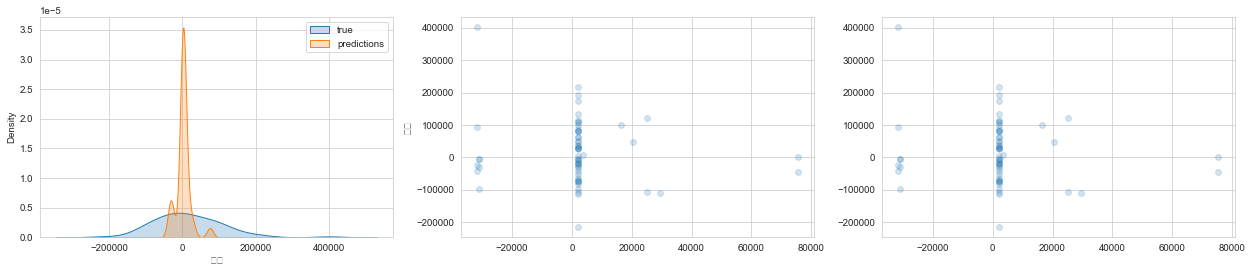


 - XGboost R2 (by lin. reg.)  : 0.015
 - XGboost R2 (by sklearn)  : -27.467
 - XGboost RMSE: 102262.591


In [20]:
plot_figsize = (18, 4) 
plot_dpi = 70
y_pred = y_pred_valid
y_true = y_valid

method_name = "XGboost"

r2a_cnn, r2b_cnn, rmse_cnn = display_kden_scatter(method_name, y_pred, y_true, plot_figsize, plot_dpi)

### HYBE Tune XGBoost(hyperparameter)

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "gamma": [0, 0.25, 0.5, 0.75, 1],
    "subsample": [0.4, 0.6, 0.8],
    "colsample_bytree": [0.25, 0.5, 0.75],
    "n_estimators": [100, 150, 200, 250, 300]
}

In [22]:
# xgboost regression 진행
xgb_reg = xgb.XGBRegressor()

# 그리드 서치 진행
search = RandomizedSearchCV(xgb_reg, param_distributions=param_grid, n_jobs=-1, cv=3, verbose=1, 
                             random_state=my_seed, return_train_score=True,
                             scoring="neg_root_mean_squared_error")

# Fitting 진행
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                         

In [23]:
search.best_params_

{'subsample': 0.4,
 'n_estimators': 250,
 'max_depth': 3,
 'learning_rate': 0.01,
 'gamma': 1,
 'colsample_bytree': 0.5}

In [24]:
search.best_score_

-112501.34254301724

In [25]:
search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [26]:
xgb_reg_best_estimator = search.best_estimator_

In [27]:
early_stop_rounds = 20

# use early stopping

xgb_reg_best_estimator.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], early_stopping_rounds=early_stop_rounds)

[0]	validation_0-rmse:98523.96997
[1]	validation_0-rmse:98465.17710
[2]	validation_0-rmse:98423.77878
[3]	validation_0-rmse:98430.53578
[4]	validation_0-rmse:98381.01003
[5]	validation_0-rmse:98348.59343
[6]	validation_0-rmse:98498.83205
[7]	validation_0-rmse:98590.87653
[8]	validation_0-rmse:98865.81743
[9]	validation_0-rmse:98842.37167
[10]	validation_0-rmse:98808.07466
[11]	validation_0-rmse:98894.94464
[12]	validation_0-rmse:98941.09218
[13]	validation_0-rmse:98957.84306
[14]	validation_0-rmse:99040.05110
[15]	validation_0-rmse:99159.63361
[16]	validation_0-rmse:99120.78307
[17]	validation_0-rmse:99131.00183
[18]	validation_0-rmse:99157.68560
[19]	validation_0-rmse:99109.41832
[20]	validation_0-rmse:99070.56445
[21]	validation_0-rmse:99077.18474
[22]	validation_0-rmse:99107.24703
[23]	validation_0-rmse:99114.20882


D:\Users\uj200\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:99079.79674
[25]	validation_0-rmse:99015.27719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [28]:
y_pred_valid_tuned = xgb_reg_best_estimator.predict(X_valid)
#y_pred_valid_tuned

D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


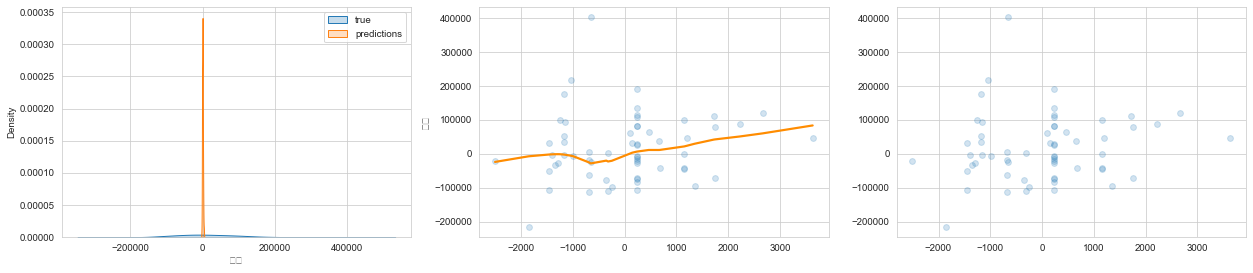


 - XGboost tuned R2 (by lin. reg.)  : 0.018
 - XGboost tuned R2 (by sklearn)  : -7240.507
 - XGboost tuned RMSE: 98348.594


In [29]:
plot_figsize = (18, 4) # width and height in inches
plot_dpi = 70
y_pred = y_pred_valid_tuned
y_true = y_valid

method_name = "XGboost tuned"

r2a_cnn, r2b_cnn, rmse_cnn = display_kden_scatter(method_name, y_pred, y_true, plot_figsize, plot_dpi)

In [30]:
# feature importance
print(xgb_reg_best_estimator.feature_importances_)

[0.05977568 0.06517289 0.05735727 0.03006314 0.06185998 0.1377445
 0.04338866 0.07966283 0.0284682  0.00224311 0.02309703 0.01904502
 0.03305612 0.03368858 0.02544631 0.0295669  0.02725745 0.01883369
 0.02799511 0.00563007 0.04302754 0.04127981 0.05082786 0.05551228]


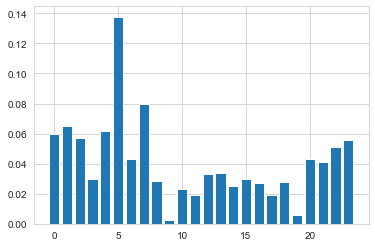

In [31]:
from matplotlib import pyplot
# plot
pyplot.bar(range(len(xgb_reg_best_estimator.feature_importances_)), xgb_reg_best_estimator.feature_importances_)
pyplot.show();

### YG

In [32]:
# train, test split

# 특정 칼럼 제외한 결과 저장
columns_to_exclude = ['종가']  # 제외할 칼럼 이름
selected_columns = [col for col in data_YG.columns if col not in columns_to_exclude]

X = data_YG[selected_columns]
y = data_YG['종가']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [33]:
X_train.describe()

,views_BB,count_BB,npv_BB,npr_BB,views_BLPK,count_BLPK,npv_BLPK,npr_BLPK,views_WN,count_WN,npv_WN,npr_WN
count,1.800000e+02,180.000000,180.000000,180.000000,1.800000e+02,180.000000,180.000000,180.000000,1.800000e+02,180.000000,180.000000,180.000000
mean,3.946938e+05,1.027778,0.013736,27.107119,8.915825e+06,1.211111,0.026984,37.285033,3.651042e+05,1.188889,0.032436,23.692483
std,6.850848e+05,0.195781,0.006749,50.954529,5.616829e+07,0.732249,0.016584,24.207505,1.939541e+06,1.102505,0.018450,14.207889
min,1.415900e+04,1.000000,0.002116,1.300000,1.185000e+04,1.000000,0.002955,4.425321,1.070800e+04,1.000000,0.002150,0.829333
25%,2.968640e+05,1.000000,0.013084,19.685714,2.084487e+06,1.000000,0.023517,33.515882,1.687860e+05,1.000000,0.030093,21.834061
50%,2.968640e+05,1.000000,0.013084,19.685714,2.084487e+06,1.000000,0.023517,33.515882,1.687860e+05,1.000000,0.030093,21.834061
75%,2.968640e+05,1.000000,0.013084,19.685714,2.084487e+06,1.000000,0.023517,33.515882,1.687860e+05,1.000000,0.030093,21.834061
max,8.487274e+06,3.000000,0.080891,623.000000,6.834001e+08,5.000000,0.134767,230.188679,2.592011e+07,14.000000,0.161695,130.769231


In [34]:
from sklearn.preprocessing import StandardScaler

# load scaler
scaler = StandardScaler()

# scale train and valid sets

# transform dataframes (take out first column which is label)
X_train = pd.DataFrame(scaler.fit_transform(X_train), dtype='float32')
X_valid = pd.DataFrame(scaler.transform(X_valid), dtype='float32')

In [35]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.143198,-0.142278,-0.096844,-0.146054,-0.121962,-0.289109,-0.209619,-0.156136,-0.181418,-0.171805,-0.914087,1.461532
1,-0.143198,-0.142278,-0.096844,-0.146054,-0.121962,-0.289109,-0.209619,-0.156136,-0.101501,-0.171805,-0.127298,-0.131167
2,-0.143198,-0.142278,-0.096844,-0.146054,-0.121962,-0.289109,-0.209619,-0.156136,-0.101501,-0.171805,-0.127298,-0.131167
3,-0.143198,-0.142278,-0.096844,-0.146054,-0.121962,-0.289109,-0.209619,-0.156136,-0.101501,-0.171805,-0.127298,-0.131167
4,-0.143198,-0.142278,-0.096844,-0.146054,-0.121962,-0.289109,-0.209619,-0.156136,-0.101501,-0.171805,-0.127298,-0.131167


In [36]:
xgb_regressor = xgb.XGBRegressor(random_state=my_seed, nthread=-1)

In [37]:
%%time

early_stop_rounds = 20

# use early stopping

xgb_regressor.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], early_stopping_rounds=early_stop_rounds)

[0]	validation_0-rmse:4201.92521
[1]	validation_0-rmse:4442.62819
[2]	validation_0-rmse:4806.68951
[3]	validation_0-rmse:4938.81218
[4]	validation_0-rmse:4932.24476
[5]	validation_0-rmse:5123.30793
[6]	validation_0-rmse:5145.22432
[7]	validation_0-rmse:5163.57164
[8]	validation_0-rmse:5181.45515
[9]	validation_0-rmse:5179.87400
[10]	validation_0-rmse:5183.40488
[11]	validation_0-rmse:5199.59817
[12]	validation_0-rmse:5197.29796
[13]	validation_0-rmse:5224.82870
[14]	validation_0-rmse:5244.91091
[15]	validation_0-rmse:5220.02713
[16]	validation_0-rmse:5251.99126
[17]	validation_0-rmse:5263.40903
[18]	validation_0-rmse:5255.84670
[19]	validation_0-rmse:5236.73943
[20]	validation_0-rmse:5251.36336
Wall time: 113 ms


D:\Users\uj200\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, nthread=-1, num_parallel_tree=None,
             predictor=None, ...)

In [38]:
# get validation set prediction results

y_pred_valid = xgb_regressor.predict(X_valid)
#y_pred_valid

D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


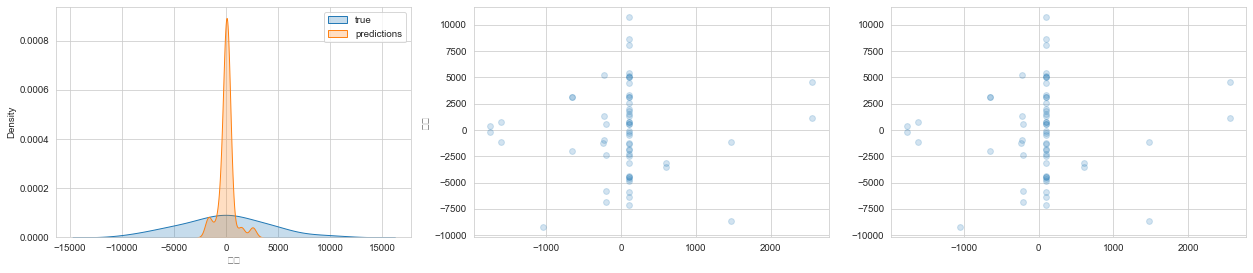


 - XGboost R2 (by lin. reg.)  : 0.002
 - XGboost R2 (by sklearn)  : -31.479
 - XGboost RMSE: 4201.925


In [39]:
plot_figsize = (18, 4) # width and height in inches
plot_dpi = 70
y_pred = y_pred_valid
y_true = y_valid

method_name = "XGboost"

r2a_cnn, r2b_cnn, rmse_cnn = display_kden_scatter(method_name, y_pred, y_true, plot_figsize, plot_dpi)

### YG_Tune XGBoost(hyperparameter)

In [40]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "gamma": [0, 0.25, 0.5, 0.75, 1],
    "subsample": [0.4, 0.6, 0.8],
    "colsample_bytree": [0.25, 0.5, 0.75],
    "n_estimators": [100, 150, 200, 250, 300]
}

In [41]:
# Init classifier
xgb_reg = xgb.XGBRegressor()

# Init Grid Search
search = RandomizedSearchCV(xgb_reg, param_distributions=param_grid, n_jobs=-1, cv=3, verbose=1, 
                             random_state=my_seed, return_train_score=True,
                             scoring="neg_root_mean_squared_error")

# Fit
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                         

In [42]:
search.best_params_

{'subsample': 0.4,
 'n_estimators': 250,
 'max_depth': 6,
 'learning_rate': 0.01,
 'gamma': 0.75,
 'colsample_bytree': 0.75}

In [43]:
search.best_score_

-4358.511339026851

In [44]:
search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.75, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
xgb_reg_best_estimator = search.best_estimator_

In [46]:
early_stop_rounds = 20

# use early stopping

xgb_reg_best_estimator.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], early_stopping_rounds=early_stop_rounds)

[0]	validation_0-rmse:4164.05909
[1]	validation_0-rmse:4161.68742
[2]	validation_0-rmse:4164.59251
[3]	validation_0-rmse:4161.81541
[4]	validation_0-rmse:4160.48687
[5]	validation_0-rmse:4162.62527
[6]	validation_0-rmse:4162.57797
[7]	validation_0-rmse:4165.09604
[8]	validation_0-rmse:4163.12035
[9]	validation_0-rmse:4162.78185
[10]	validation_0-rmse:4164.20656
[11]	validation_0-rmse:4157.53167
[12]	validation_0-rmse:4161.85234
[13]	validation_0-rmse:4158.64226
[14]	validation_0-rmse:4159.43565
[15]	validation_0-rmse:4161.35882
[16]	validation_0-rmse:4162.07615
[17]	validation_0-rmse:4160.32846
[18]	validation_0-rmse:4160.43190
[19]	validation_0-rmse:4162.11892
[20]	validation_0-rmse:4162.60618
[21]	validation_0-rmse:4161.57233
[22]	validation_0-rmse:4162.19012
[23]	validation_0-rmse:4160.43800
[24]	validation_0-rmse:4159.09762
[25]	validation_0-rmse:4160.41311
[26]	validation_0-rmse:4160.44443
[27]	validation_0-rmse:4161.78022
[28]	validation_0-rmse:4161.98394
[29]	validation_0-rmse:4

D:\Users\uj200\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.75, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
y_pred_valid_tuned = xgb_reg_best_estimator.predict(X_valid)
#y_pred_valid_tuned

D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


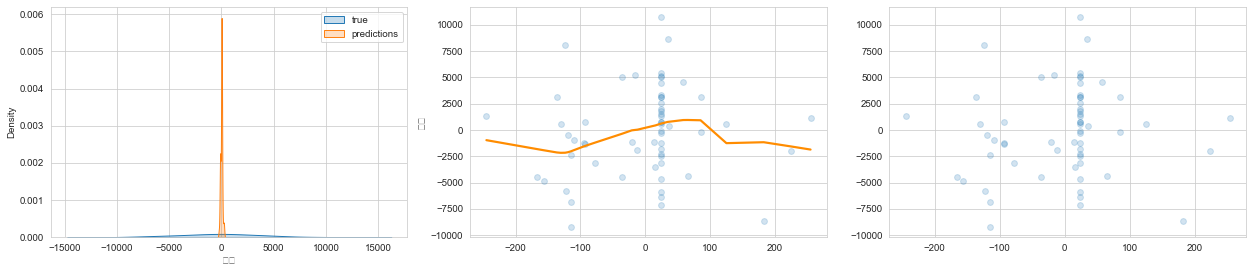


 - XGboost tuned R2 (by lin. reg.)  : 0.009
 - XGboost tuned R2 (by sklearn)  : -2153.032
 - XGboost tuned RMSE: 4157.532


In [48]:
plot_figsize = (18, 4) # width and height in inches
plot_dpi = 70
y_pred = y_pred_valid_tuned
y_true = y_valid

method_name = "XGboost tuned"

r2a_cnn, r2b_cnn, rmse_cnn = display_kden_scatter(method_name, y_pred, y_true, plot_figsize, plot_dpi)

In [49]:
# feature importance
print(xgb_reg_best_estimator.feature_importances_)

[0.06714958 0.11189666 0.03627169 0.05607537 0.09130938 0.03755738
 0.04501152 0.05288246 0.06410414 0.2289999  0.11915245 0.08958947]


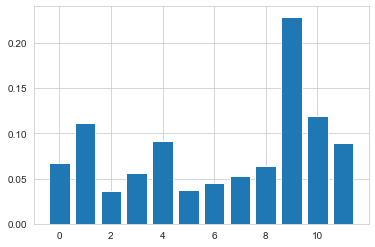

In [50]:
from matplotlib import pyplot
# plot
pyplot.bar(range(len(xgb_reg_best_estimator.feature_importances_)), xgb_reg_best_estimator.feature_importances_)
pyplot.show();

### JYP

In [51]:
# train, test split

# 특정 칼럼 제외한 결과 저장
columns_to_exclude = ['종가']  # 제외할 칼럼 이름
selected_columns = [col for col in data_JYP.columns if col not in columns_to_exclude]

X = data_JYP[selected_columns]
y = data_JYP['종가']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [52]:
X_train.head()

,views_DAY6,count_DAY6,npv_DAY6,npr_DAY6,views_TWI,count_TWI,npv_TWI,npr_TWI,views_SKZ,count_SKZ,npv_SKZ,npr_SKZ,views_ITZY,count_ITZY,npv_ITZY,npr_ITZY,views_NMX,count_NMX,npv_NMX,npr_NMX
2022-06-27,44704.0,1.0,0.014585,93.142857,3204453.0,1.0,0.014355,37.797864,3925108.0,1.0,0.091354,30.627806,451991.0,1.0,0.018637,34.250000,4419047.0,1.0,0.047522,227.518960
2022-06-14,55931.0,1.0,0.028719,31.571429,1393485.0,1.0,0.032533,54.346879,3925108.0,1.0,0.091354,30.627806,451991.0,1.0,0.018637,34.250000,1471293.5,1.0,0.036169,104.174774
2022-08-31,37548.0,1.0,0.017657,31.571429,1393485.0,1.0,0.032533,54.346879,3925108.0,1.0,0.091354,30.627806,451991.0,1.0,0.018637,34.250000,1471293.5,1.0,0.036169,104.174774
2022-12-20,55931.0,1.0,0.028719,31.571429,1393485.0,1.0,0.032533,54.346879,3925108.0,1.0,0.091354,30.627806,451991.0,1.0,0.018637,34.250000,1471293.5,1.0,0.036169,104.174774
2022-11-02,55931.0,1.0,0.028719,31.571429,1393485.0,1.0,0.032533,54.346879,3925108.0,1.0,0.091354,30.627806,958231.0,1.0,0.010436,17.094017,1471293.5,1.0,0.036169,104.174774


In [53]:
from sklearn.preprocessing import StandardScaler

# load scaler
scaler = StandardScaler()

# scale train and valid sets

# transform dataframes (take out first column which is label)
X_train = pd.DataFrame(scaler.fit_transform(X_train), dtype='float32')
X_valid = pd.DataFrame(scaler.transform(X_valid), dtype='float32')

In [54]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.313786,-0.146247,-0.947565,1.943833,0.008636,-0.264741,-1.484349,-0.366499,-0.092745,-0.183494,0.062295,-0.161489,-0.124586,-0.142278,-0.124763,-0.120435,0.151917,-0.354768,1.374058,1.184566
1,-0.176934,-0.146247,-0.153690,-0.155233,-0.168812,-0.264741,-0.114309,-0.169403,-0.092745,-0.183494,0.062295,-0.161489,-0.124586,-0.142278,-0.124763,-0.120435,-0.159260,-0.354768,-0.009887,-0.220046
2,-0.401014,-0.146247,-0.774989,-0.155233,-0.168812,-0.264741,-0.114309,-0.169403,-0.092745,-0.183494,0.062295,-0.161489,-0.124586,-0.142278,-0.124763,-0.120435,-0.159260,-0.354768,-0.009887,-0.220046
3,-0.176934,-0.146247,-0.153690,-0.155233,-0.168812,-0.264741,-0.114309,-0.169403,-0.092745,-0.183494,0.062295,-0.161489,-0.124586,-0.142278,-0.124763,-0.120435,-0.159260,-0.354768,-0.009887,-0.220046
4,-0.176934,-0.146247,-0.153690,-0.155233,-0.168812,-0.264741,-0.114309,-0.169403,-0.092745,-0.183494,0.062295,-0.161489,-0.091020,-0.142278,-0.539313,-1.697979,-0.159260,-0.354768,-0.009887,-0.220046


In [55]:
xgb_regressor = xgb.XGBRegressor(random_state=my_seed, nthread=-1)

In [56]:
%%time

early_stop_rounds = 20

# use early stopping

xgb_regressor.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], early_stopping_rounds=early_stop_rounds)

[0]	validation_0-rmse:16419.45360
[1]	validation_0-rmse:16363.63786
[2]	validation_0-rmse:16425.61043
[3]	validation_0-rmse:17699.83078
[4]	validation_0-rmse:18037.94797
[5]	validation_0-rmse:18863.17771
[6]	validation_0-rmse:19691.66875
[7]	validation_0-rmse:19687.32496
[8]	validation_0-rmse:19755.80623
[9]	validation_0-rmse:19993.97781
[10]	validation_0-rmse:20144.80553
[11]	validation_0-rmse:20285.72745
[12]	validation_0-rmse:20340.64125
[13]	validation_0-rmse:20506.00690
[14]	validation_0-rmse:20648.33672
[15]	validation_0-rmse:20785.41366
[16]	validation_0-rmse:20873.93340
[17]	validation_0-rmse:20916.92053
[18]	validation_0-rmse:20941.12809
[19]	validation_0-rmse:20933.74671


D:\Users\uj200\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:21083.22899
Wall time: 229 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, nthread=-1, num_parallel_tree=None,
             predictor=None, ...)

In [57]:
# get validation set prediction results

y_pred_valid = xgb_regressor.predict(X_valid)
#y_pred_valid

D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


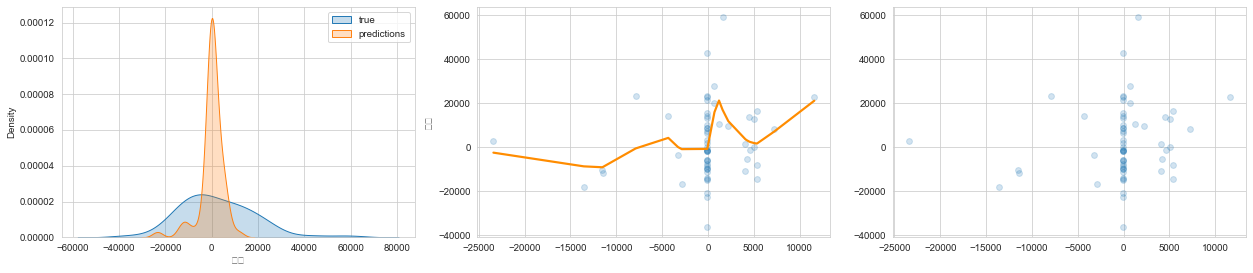


 - XGboost R2 (by lin. reg.)  : 0.026
 - XGboost R2 (by sklearn)  : -9.567
 - XGboost RMSE: 16363.638


In [58]:
plot_figsize = (18, 4) # width and height in inches
plot_dpi = 70
y_pred = y_pred_valid
y_true = y_valid

method_name = "XGboost"

r2a_cnn, r2b_cnn, rmse_cnn = display_kden_scatter(method_name, y_pred, y_true, plot_figsize, plot_dpi)

### JYP Tune XGBoost(hyperparameter)

In [59]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "gamma": [0, 0.25, 0.5, 0.75, 1],
    "subsample": [0.4, 0.6, 0.8],
    "colsample_bytree": [0.25, 0.5, 0.75],
    "n_estimators": [100, 150, 200, 250, 300]
}

In [60]:
# Init classifier
xgb_reg = xgb.XGBRegressor()

# Init Grid Search
search = RandomizedSearchCV(xgb_reg, param_distributions=param_grid, n_jobs=-1, cv=3, verbose=1, 
                             random_state=my_seed, return_train_score=True,
                             scoring="neg_root_mean_squared_error")

# Fit
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                         

In [61]:
search.best_params_

{'subsample': 0.4,
 'n_estimators': 250,
 'max_depth': 3,
 'learning_rate': 0.01,
 'gamma': 1,
 'colsample_bytree': 0.5}

In [62]:
search.best_score_

-18063.589353130486

In [63]:
search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [64]:
xgb_reg_best_estimator = search.best_estimator_

In [65]:
early_stop_rounds = 20

# use early stopping

xgb_reg_best_estimator.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], early_stopping_rounds=early_stop_rounds)

[0]	validation_0-rmse:16372.21701
[1]	validation_0-rmse:16376.87185
[2]	validation_0-rmse:16375.49648
[3]	validation_0-rmse:16384.78300
[4]	validation_0-rmse:16365.58718
[5]	validation_0-rmse:16372.14334
[6]	validation_0-rmse:16385.78660
[7]	validation_0-rmse:16429.93516
[8]	validation_0-rmse:16434.38582
[9]	validation_0-rmse:16444.66245
[10]	validation_0-rmse:16451.99153
[11]	validation_0-rmse:16454.19371
[12]	validation_0-rmse:16423.93673
[13]	validation_0-rmse:16440.38989
[14]	validation_0-rmse:16410.09452
[15]	validation_0-rmse:16445.31890
[16]	validation_0-rmse:16453.31720
[17]	validation_0-rmse:16443.97684
[18]	validation_0-rmse:16459.04633
[19]	validation_0-rmse:16464.55463
[20]	validation_0-rmse:16473.09293
[21]	validation_0-rmse:16478.12520
[22]	validation_0-rmse:16469.04760
[23]	validation_0-rmse:16471.66141


D:\Users\uj200\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [66]:
y_pred_valid_tuned = xgb_reg_best_estimator.predict(X_valid)
#y_pred_valid_tuned

D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Users\uj200\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


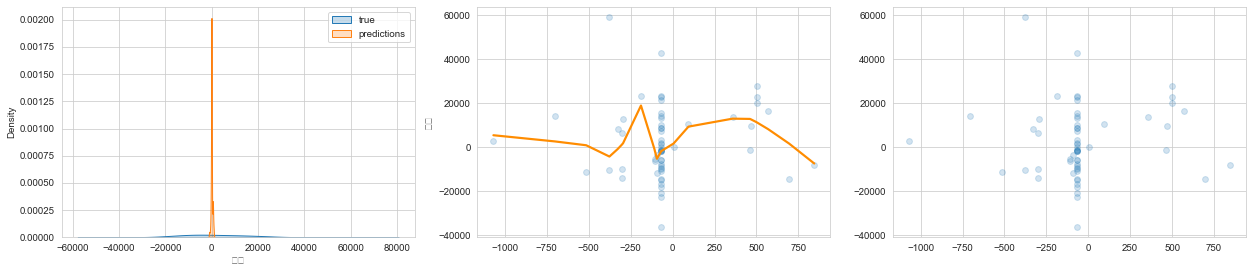


 - XGboost tuned R2 (by lin. reg.)  : 0.003
 - XGboost tuned R2 (by sklearn)  : -2856.911
 - XGboost tuned RMSE: 16365.587


In [67]:
plot_figsize = (18, 4) # width and height in inches
plot_dpi = 70
y_pred = y_pred_valid_tuned
y_true = y_valid

method_name = "XGboost tuned"

r2a_cnn, r2b_cnn, rmse_cnn = display_kden_scatter(method_name, y_pred, y_true, plot_figsize, plot_dpi)

In [68]:
# feature importance
print(xgb_reg_best_estimator.feature_importances_)

[0.03912576 0.05778215 0.06600951 0.04145413 0.05091833 0.04865692
 0.099603   0.06107458 0.01311629 0.02907365 0.05446952 0.02755633
 0.01977498 0.04320393 0.07976516 0.07508826 0.06346957 0.03081975
 0.04781378 0.05122443]


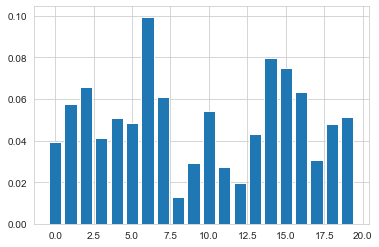

In [69]:
from matplotlib import pyplot
# plot
pyplot.bar(range(len(xgb_reg_best_estimator.feature_importances_)), xgb_reg_best_estimator.feature_importances_)
pyplot.show();